In [310]:
!set CUDA_LAUNCH_BLOCKING=1
!set TORCH_USE_CUDA_DSA=1

In [311]:
"""
Train a small convolutional neural network (LeNet architecture) on your dataset,
and a small 2 layer fully connected neural network (FCN) with a similar number
of total parameters. Training requirements: 20 epochs, with Cross-Entropy Loss.
You can use any optimizer (e.g. SGD, Adam, SAM, Adadelta, etc...). State the
optimizer you use. To receive 
"""

# https://medium.com/@deepeshdeepakdd2/lenet-5-implementation-on-mnist-in-pytorch-c6f2ee306e37

import torch
SEED = 123
torch.manual_seed(SEED) 

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
# from torchsummary import summary
from torchinfo import summary
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import warnings
from tqdm import tqdm
from datetime import datetime
warnings.filterwarnings('ignore')

from PIL import Image
import os
import glob

# check OS is Window or Mac
import platform

if platform.system() == 'Windows':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
elif platform.system() == 'Darwin':
    try:
        device = torch.device("mps")
    except:
        device = torch.device("cpu")

float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind': float_formatter})

print(device)

cuda


In [312]:
print(len(glob.glob(os.path.join('./img/', '**/*.png'), recursive=True)))

5000


In [313]:
def random_image(folder):
    """random image from folder and subdirectories"""
    image_files = glob.glob(os.path.join(folder, '**/*.png'), recursive=True) + glob.glob(os.path.join(folder, '**/*.jpg'), recursive=True)
    # print(image_files)
    path = np.random.choice(image_files)
    print(f'Opening image: {path}')
    img = Image.open(path)
    return img

In [314]:
# !nvidia-smi

In [315]:
# !nvcc --version

Opening image: img\10\3281.png
(96, 96)
torch.Size([3, 96, 96])


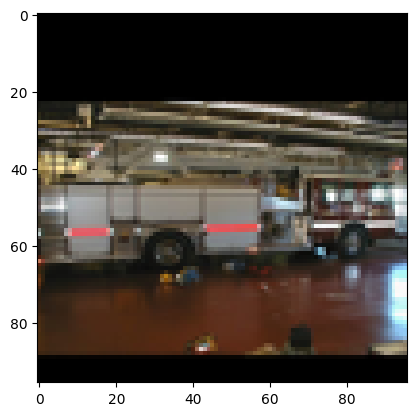

In [316]:
im = random_image('img')
print(im.size)

im_tensor = transforms.ToTensor()(im)
print(im_tensor.shape)

plt.imshow(im)

# **LeNet5V1**

In [338]:
class LeNet5V1(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            # 1
            nn.Conv2d(in_channels=3,    # cantidad de canales RGB == 3
                      out_channels=6, 
                      kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),

            # 2
            nn.Conv2d(in_channels=6, 
                      out_channels=16,
                      kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*22*22, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.classifier(self.feature(x))

In [318]:
model = LeNet5V1()

In [319]:
summary(model=model, input_size=(1, 3, 96, 96), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5V1 (LeNet5V1)                      [1, 3, 96, 96]       [1, 10]              --                   True
├─Sequential (feature)                   [1, 3, 96, 96]       [1, 16, 22, 22]      --                   True
│    └─Conv2d (0)                        [1, 3, 96, 96]       [1, 6, 96, 96]       456                  True
│    └─ReLU (1)                          [1, 6, 96, 96]       [1, 6, 96, 96]       --                   --
│    └─AvgPool2d (2)                     [1, 6, 96, 96]       [1, 6, 48, 48]       --                   --
│    └─Conv2d (3)                        [1, 6, 48, 48]       [1, 16, 44, 44]      2,416                True
│    └─ReLU (4)                          [1, 16, 44, 44]      [1, 16, 44, 44]      --                   --
│    └─AvgPool2d (5)                     [1, 16, 44, 44]      [1, 16, 22, 22]      --                   --
├─Sequential (classifi

# **dataset**

In [320]:
import albumentations as A  # image augmentations
from torch.utils.data import Dataset, DataLoader    # dataset abstract class | parallel loader
import cv2

In [321]:
class CustomDataset(Dataset):
    def __init__(self, folder, transform):
        self.transform = transform
        
        self.imgs = glob.glob(os.path.join(folder, '**/*.png'), recursive=True)
        self.labels = [int(os.path.basename(os.path.dirname(path))) - 1 for path in self.imgs]

    def __len__(self):
        return len(self.imgs) * 2

    def __getitem__(self, idx):
        """Retrieves an image and its target from the dataset.

        Args:
            idx (int): index of the image to be retrieved

        Returns:
            Tuple[torch.Tensor, Dict[str, torch.Tensor]]: image and target
        """

        if idx >= self.__len__() or idx < 0:
            raise IndexError("Index out of range")
        # print(f'idx {idx}', end=' ')

        rotation_degrees = [0, 180]  # , 90, 270, 45, 135, 225, 315

        original_idx = idx // 2
        rotation_idx = idx % 2

        img_path = self.imgs[original_idx]
        # print(img_path)
        image = np.asarray(Image.open(img_path).convert("RGB"))

        angle = rotation_degrees[rotation_idx]
        transform = A.Compose([
                    # https://albumentations.ai/docs/api_reference/augmentations/geometric/rotate/
                    # A.Resize(height=1000, width=1000, p=1),
                    A.Rotate(limit=[angle, angle], p=1, rotate_method='ellipse', border_mode=cv2.BORDER_CONSTANT),
                ]
            )

        image = transform(image=image)['image']
        image = transforms.ToTensor()(image)
        target = self.labels[original_idx]
        # # display tensor
        # print(target)
        # plt.imshow(image.permute(1, 2, 0))
        # plt.show()
        # return
        return image, target

cd = CustomDataset('img', None)
print(len(cd))
cd[0]

10000


(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1412, 0.1412, 0.1412,  ..., 0.1412, 0.1412, 0.1412],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1725, 0.1725, 0.1725,  ...,

In [322]:
import os
from sklearn.model_selection import StratifiedShuffleSplit
from shutil import copyfile

def create_train_test_folders(root_folder, output_folder, test_size=0.3, random_state=SEED):
    # Create the output folders if they don't exist
    train_folder = os.path.join(output_folder, 'train')
    test_folder = os.path.join(output_folder, 'test')
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Collect image paths and labels
    data = []
    labels = []
    for label in os.listdir(root_folder):
        label_path = os.path.join(root_folder, label)
        if os.path.isdir(label_path):
            for image in os.listdir(label_path):
                image_path = os.path.join(label_path, image)
                data.append(image_path)
                labels.append(label)

    # Perform stratified split
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    for train_index, test_index in stratified_split.split(data, labels):
        train_data = [data[i] for i in train_index]
        test_data = [data[i] for i in test_index]

    # Copy files to train folder
    for image_path in train_data:
        label = os.path.basename(os.path.dirname(image_path))
        dest_folder = os.path.join(train_folder, label)
        os.makedirs(dest_folder, exist_ok=True)
        copyfile(image_path, os.path.join(dest_folder, os.path.basename(image_path)))

    # Copy files to test folder
    for image_path in test_data:
        label = os.path.basename(os.path.dirname(image_path))
        dest_folder = os.path.join(test_folder, label)
        os.makedirs(dest_folder, exist_ok=True)
        copyfile(image_path, os.path.join(dest_folder, os.path.basename(image_path)))

create_train_test_folders(root_folder='./img/', output_folder='./data_split')

In [323]:
print(len(glob.glob(os.path.join('./data_split/train/', '**/*.png'), recursive=True)))
print(len(glob.glob(os.path.join('./data_split/test/', '**/*.png'), recursive=True)))

# print number of images per class
print([
    len(glob.glob(os.path.join(f'./data_split/train/{i}', '**/*.png'), recursive=True)) for i in range(1, 11)
])

4697
2197
[473, 469, 465, 468, 474, 469, 469, 470, 467, 473]


In [324]:
from sklearn.model_selection import StratifiedShuffleSplit
dataset_path = './img/'

batch_size = 8      # TODO: cambiarlo a lo que aguante su computadora y relativo a la cantidad de imagenes que tengan

transform = transforms.Compose([
    # transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

# train_dataset = CustomDataset('./data_split/train', transform=None)
# val_dataset = CustomDataset('./data_split/test', transform=None)

train_dataset = ImageFolder(root='./data_split/train', transform=transform)
val_dataset = ImageFolder(root='./data_split/test', transform=transform)

print(len(train_dataset), len(val_dataset))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

print(len(train_dataset), len(val_dataset))

4697 2197
4697 2197


In [325]:
from torchmetrics import Accuracy

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
accuracy = Accuracy(task='multiclass', num_classes=10)

In [326]:
from sklearn.metrics import f1_score

os.makedirs("./models", exist_ok=True)
timestamp = datetime.now().strftime("%Y-%m-%d")
experiment_name = "STL"
model_name = "LeNet5"

accuracy = accuracy.to(device)
model = model.to(device)

EPOCHS = 20

best_f1_macro = 0.0
best_model_path = None

for epoch in tqdm(range(EPOCHS)):
    # Training loop
    train_loss, train_acc, train_f1_macro = 0.0, 0.0, 0.0

    y_true = []
    y_pred = []
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        
        model.train()
        
        predictions = model(X)
        
        loss = loss_fn(predictions, y)
        train_loss += loss.item()
        
        acc = accuracy(predictions, y)
        train_acc += acc
        
        y_true.extend(torch.argmax(predictions, dim=1).tolist())
        y_pred.extend(y.tolist())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_f1_macro = f1_score(y_true, y_pred, average='macro')
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    
    # Validation loop
    val_loss, val_acc = 0.0, 0.0
    y_true = []
    y_pred = []
    
    model.eval()
    with torch.inference_mode():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)
            
            predictions = model(X)
            
            loss = loss_fn(predictions, y)
            val_loss += loss.item()
            
            acc = accuracy(predictions, y)
            val_acc += acc

            y_pred.extend(torch.argmax(model(X), dim=1).tolist())
            y_true.extend(y.tolist())
            
        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)
        
        val_f1_macro = f1_score(y_true, y_pred, average='macro')
        
        if val_f1_macro > best_f1_macro:
            best_f1_macro = val_f1_macro
            best_model_path = f"./models/best_model_{model_name}.pth"
            torch.save(model.state_dict(), best_model_path)
    
    print(f"Epoch: {epoch}| Train loss: {train_loss:.5f}| Train acc: {train_acc:.5f}| Train F1 Macro: {train_f1_macro:.5f}| Val loss: {val_loss:.5f}| Val acc: {val_acc:.5f}| Val F1 Macro: {val_f1_macro:.5f}")

print(f"Best F1 Macro: {best_f1_macro:.5f} | Best Model Path: {best_model_path}")

  5%|▌         | 1/20 [00:40<12:58, 40.98s/it]

Epoch: 0| Train loss: 1.93821| Train acc: 0.25425| Train F1 Macro: 0.23975| Val loss: 1.62778| Val acc: 0.38391| Val F1 Macro: 0.36346


 10%|█         | 2/20 [00:51<06:58, 23.23s/it]

Epoch: 1| Train loss: 1.54289| Train acc: 0.41156| Train F1 Macro: 0.40115| Val loss: 1.34597| Val acc: 0.47636| Val F1 Macro: 0.44747


 15%|█▌        | 3/20 [01:02<04:57, 17.53s/it]

Epoch: 2| Train loss: 1.32022| Train acc: 0.49809| Train F1 Macro: 0.49240| Val loss: 1.13020| Val acc: 0.60082| Val F1 Macro: 0.58901


 20%|██        | 4/20 [01:13<03:57, 14.84s/it]

Epoch: 3| Train loss: 1.06549| Train acc: 0.61246| Train F1 Macro: 0.61022| Val loss: 0.95293| Val acc: 0.66473| Val F1 Macro: 0.65988


 25%|██▌       | 5/20 [01:24<03:25, 13.68s/it]

Epoch: 4| Train loss: 0.80483| Train acc: 0.70940| Train F1 Macro: 0.70939| Val loss: 0.69980| Val acc: 0.77745| Val F1 Macro: 0.77989


 30%|███       | 6/20 [01:35<02:58, 12.73s/it]

Epoch: 5| Train loss: 0.50322| Train acc: 0.82419| Train F1 Macro: 0.82371| Val loss: 0.59540| Val acc: 0.80791| Val F1 Macro: 0.80911


 35%|███▌      | 7/20 [01:46<02:37, 12.09s/it]

Epoch: 6| Train loss: 0.30168| Train acc: 0.89626| Train F1 Macro: 0.89611| Val loss: 0.51774| Val acc: 0.87064| Val F1 Macro: 0.87036


 40%|████      | 8/20 [01:57<02:20, 11.72s/it]

Epoch: 7| Train loss: 0.18938| Train acc: 0.93750| Train F1 Macro: 0.93751| Val loss: 0.41346| Val acc: 0.90727| Val F1 Macro: 0.90819


 45%|████▌     | 9/20 [02:08<02:05, 11.44s/it]

Epoch: 8| Train loss: 0.12435| Train acc: 0.96046| Train F1 Macro: 0.96044| Val loss: 0.45004| Val acc: 0.90227| Val F1 Macro: 0.90238


 50%|█████     | 10/20 [02:18<01:51, 11.15s/it]

Epoch: 9| Train loss: 0.09939| Train acc: 0.96684| Train F1 Macro: 0.96680| Val loss: 0.52060| Val acc: 0.90173| Val F1 Macro: 0.90232


 55%|█████▌    | 11/20 [02:29<01:38, 10.94s/it]

Epoch: 10| Train loss: 0.10922| Train acc: 0.96747| Train F1 Macro: 0.96743| Val loss: 0.56355| Val acc: 0.91045| Val F1 Macro: 0.91042


 60%|██████    | 12/20 [02:39<01:26, 10.82s/it]

Epoch: 11| Train loss: 0.06987| Train acc: 0.97662| Train F1 Macro: 0.97658| Val loss: 0.55173| Val acc: 0.92473| Val F1 Macro: 0.92492


 65%|██████▌   | 13/20 [02:50<01:15, 10.81s/it]

Epoch: 12| Train loss: 0.08117| Train acc: 0.97662| Train F1 Macro: 0.97660| Val loss: 0.50269| Val acc: 0.91182| Val F1 Macro: 0.91209


 70%|███████   | 14/20 [03:02<01:07, 11.19s/it]

Epoch: 13| Train loss: 0.04406| Train acc: 0.98639| Train F1 Macro: 0.98637| Val loss: 0.58520| Val acc: 0.92227| Val F1 Macro: 0.92217


 75%|███████▌  | 15/20 [03:14<00:56, 11.34s/it]

Epoch: 14| Train loss: 0.07566| Train acc: 0.97640| Train F1 Macro: 0.97637| Val loss: 1.00659| Val acc: 0.87273| Val F1 Macro: 0.87236


 80%|████████  | 16/20 [03:25<00:45, 11.40s/it]

Epoch: 15| Train loss: 0.10613| Train acc: 0.96875| Train F1 Macro: 0.96868| Val loss: 0.57923| Val acc: 0.91745| Val F1 Macro: 0.91795


 85%|████████▌ | 17/20 [03:36<00:33, 11.13s/it]

Epoch: 16| Train loss: 0.02663| Train acc: 0.99192| Train F1 Macro: 0.99191| Val loss: 0.63826| Val acc: 0.91864| Val F1 Macro: 0.91868


 90%|█████████ | 18/20 [03:47<00:22, 11.05s/it]

Epoch: 17| Train loss: 0.03224| Train acc: 0.99086| Train F1 Macro: 0.99085| Val loss: 0.70031| Val acc: 0.92727| Val F1 Macro: 0.92706


 95%|█████████▌| 19/20 [03:57<00:10, 10.96s/it]

Epoch: 18| Train loss: 0.10056| Train acc: 0.97300| Train F1 Macro: 0.97295| Val loss: 0.63630| Val acc: 0.91291| Val F1 Macro: 0.91323


100%|██████████| 20/20 [04:08<00:00, 12.43s/it]

Epoch: 19| Train loss: 0.04414| Train acc: 0.98597| Train F1 Macro: 0.98596| Val loss: 0.56061| Val acc: 0.92909| Val F1 Macro: 0.92907
Best F1 Macro: 0.92907 | Best Model Path: ./models/best_model.pth


In [341]:
model_lenet_uploaded = LeNet5V1()
model_lenet_uploaded.load_state_dict(torch.load(f"./models/best_model_{model_name}.pth"))

model_lenet_uploaded.to(device)

LeNet5V1(
  (feature): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=7744, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [342]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_true = []
y_pred = []

model_lenet_uploaded.eval()

with torch.inference_mode():
    for X, y in val_dataloader:
        X, y = X.to(device), y.to(device)
        
        y_pred.extend(torch.argmax(model_lenet_uploaded(X), dim=1).tolist())
        y_true.extend(y.tolist())

In [343]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       223
           1       0.93      0.96      0.94       223
           2       0.90      0.92      0.91       219
           3       0.97      0.93      0.95       215
           4       0.93      0.90      0.91       218
           5       0.92      0.92      0.92       224
           6       0.88      0.90      0.89       219
           7       0.92      0.91      0.92       219
           8       0.93      0.92      0.92       220
           9       0.98      0.96      0.97       217

    accuracy                           0.93      2197
   macro avg       0.93      0.93      0.93      2197
weighted avg       0.93      0.93      0.93      2197



In [344]:
print(confusion_matrix(y_true, y_pred))

[[216   2   2   0   0   0   2   0   0   1]
 [  1 213   1   3   1   0   2   0   1   1]
 [  2   1 201   1   1   7   2   2   1   1]
 [  1   7   0 201   2   1   1   0   0   2]
 [  4   1   3   1 196   1   6   2   4   0]
 [  1   1   3   0   2 205   4   5   3   0]
 [  0   0   6   0   5   2 198   5   3   0]
 [  0   2   5   0   1   3   5 200   3   0]
 [  0   1   3   0   2   3   6   3 202   0]
 [  4   1   0   2   1   0   0   0   0 209]]


In [345]:
print(confusion_matrix(y_true, y_pred, normalize='true'))

[[0.97 0.01 0.01 0.00 0.00 0.00 0.01 0.00 0.00 0.00]
 [0.00 0.96 0.00 0.01 0.00 0.00 0.01 0.00 0.00 0.00]
 [0.01 0.00 0.92 0.00 0.00 0.03 0.01 0.01 0.00 0.00]
 [0.00 0.03 0.00 0.93 0.01 0.00 0.00 0.00 0.00 0.01]
 [0.02 0.00 0.01 0.00 0.90 0.00 0.03 0.01 0.02 0.00]
 [0.00 0.00 0.01 0.00 0.01 0.92 0.02 0.02 0.01 0.00]
 [0.00 0.00 0.03 0.00 0.02 0.01 0.90 0.02 0.01 0.00]
 [0.00 0.01 0.02 0.00 0.00 0.01 0.02 0.91 0.01 0.00]
 [0.00 0.00 0.01 0.00 0.01 0.01 0.03 0.01 0.92 0.00]
 [0.02 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.96]]
